# Import Library

In [199]:
# load data
import glob
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer # https://realpython.com/k-means-clustering-python/
from sklearn.decomposition import PCA

# modelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# load/save model
import pickle

# Load Data

- input: -
- output: `X, y`

In [200]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.bitwise_not(image)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = glob.glob(path)
    images = np.array([import_image(file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [201]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

raw_X = np.empty((0, 224, 224, 3), np.uint8)
raw_y = np.empty((0))

for character in hanacaraka:
    dataset_path = "../Dataset/campuran/" + character + "/*.png"
    
    temp_X, temp_y = import_data(character, dataset_path)
    
    print("Ukuran karakter", character, ":", temp_X.shape[0])
    
    raw_X = np.append(raw_X, temp_X, axis=0)
    raw_y = np.append(raw_y, temp_y, axis=0)


Ukuran karakter ba : 21
Ukuran karakter ca : 21
Ukuran karakter da : 21
Ukuran karakter dha : 21
Ukuran karakter ga : 21
Ukuran karakter ha : 21
Ukuran karakter ja : 21
Ukuran karakter ka : 21
Ukuran karakter la : 21
Ukuran karakter ma : 21
Ukuran karakter na : 21
Ukuran karakter nga : 21
Ukuran karakter nya : 21
Ukuran karakter pa : 21
Ukuran karakter ra : 21
Ukuran karakter sa : 21
Ukuran karakter ta : 21
Ukuran karakter tha : 21
Ukuran karakter wa : 21
Ukuran karakter ya : 21


In [202]:
# Ukuran keseluruhan data
print("Jumlah data:", raw_X.shape[0])
print("Dimensi gambar:", raw_X[0].shape)

Jumlah data: 420
Dimensi gambar: (224, 224, 3)


# Augmantation & Preparation Data
List Augmented :
1. Rotate 30 CCW
2. Rotate 15 CCW + Zoom out
3. Rotate 15 CW + Zoom out
4. Rotate 30 CW
5. Shear Left
6. Shear Right
7. Normal

In [204]:
# Augmented Method
def rotate(img, degree):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), degree, 1.0)
    img_rotated = cv2.warpAffine(img, M, (w, h))
    return img_rotated

def zoom_out(img, zoom_scale):
    img_zoom = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    h, w = img.shape[0]/zoom_scale, img.shape[1]/zoom_scale
    h, w = int(h), int(w)
    x, y = (img.shape[0]-w)//2, (img.shape[1]-h)//2
    img_resize = cv2.resize(img, (h, w), interpolation = cv2.INTER_AREA)

    img_zoom[x:w+x, y:h+y] = img_resize
    return img_zoom

def shear(img, x, y):
    rows, cols = img.shape
    M = np.float32([[1, x, 0],
                    [y, 1, 0]])
    sheared_img = cv2.warpAffine(img, M, (cols, rows))
    return sheared_img

# Preprocessing Image
def equalizing(img):
    if (img.ndim == 3):
        b, g, r = cv2.split(img)
        red = cv2.equalizeHist(r)
        green = cv2.equalizeHist(g)
        blue = cv2.equalizeHist(b)
        img = cv2.merge((blue, green, red))
    else:
        img = cv2.equalizeHist(img)
    return img

def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image
    
def thresholding(image, th):
    ret, image = cv2.threshold(image, th, 255, cv2.THRESH_BINARY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

In [251]:
def dataset_aug_generator_prep(ori_img):
    ori_img = resizing(ori_img, 128)
    ori_img = grayscaling(ori_img)
#     ori_img = thresholding(ori_img, 32)
    
    ori_img = zoom_out(ori_img, 1.15)
    img_r_30_ccw = rotate(ori_img, 30)
    img_r_30_cw = rotate(ori_img, -30)
    img_r_15_ccw_z = rotate(zoom_out(ori_img, 1.3), 15)
    img_r_15_cw_z = rotate(zoom_out(ori_img, 1.3), -15)
    img_s_left = shear(ori_img, -0.15, -0.15)
    img_s_right = shear(ori_img, 0.15, 0.15)
    
    result_aug = [ori_img, img_r_30_ccw, img_r_30_cw, img_r_15_ccw_z, img_r_15_cw_z, img_s_left, img_s_right]
#     for idx, item_img in enumerate(result_aug):
#         result_aug[idx] = equalizing(result_aug[idx])
#         result_aug[idx] = thresholding(result_aug[idx], 32)
    return result_aug

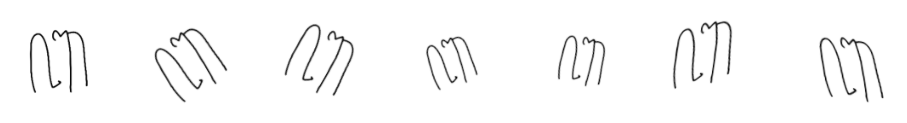

In [252]:
test_img_aug = dataset_aug_generator_prep(raw_X[0])

fig = plt.figure(figsize=(16, 4))
columns = 7
rows = 1
for i in range(1, columns*rows + 1):
    img = test_img_aug[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [253]:
X = np.empty((0, 128, 128), np.uint8)
y = np.empty((0))

for idx, img in enumerate(raw_X):
    img_aug = dataset_aug_generator_prep(img)
    
    for item_img in img_aug:
        X = np.append(X, [item_img], axis=0)
        y = np.append(y, [raw_y[idx]], axis=0)

In [254]:
X.shape

(2940, 128, 128)

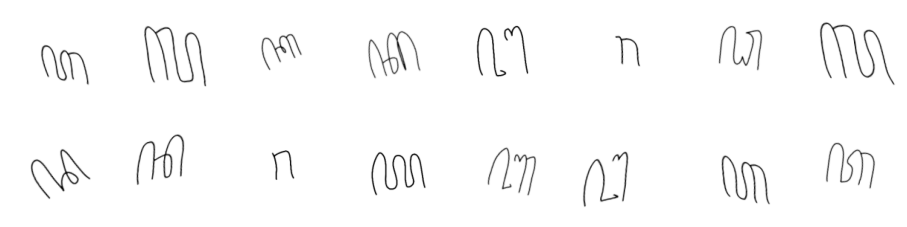

In [255]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 2
for i in range(1, columns*rows + 1):
    img = np.array(X[np.random.randint(0, X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Feature Extraction

- input: `X`
- output: `X_feature`

### Extract sift descriptors 

In [256]:
def extract_sift_features(list_image):

    image_descriptors = []
    sift = cv2.SIFT_create()
    for image in list_image:
        _, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)

    return image_descriptors

def split_all_descriptors(image_descriptors):
    all_descriptors = []
    for descriptor in image_descriptors:
        if descriptor is not None:
            for des in descriptor:
                all_descriptors.append(des)
    
    return np.array(all_descriptors)

In [257]:
image_descriptors = extract_sift_features(X)
all_descriptors = split_all_descriptors(image_descriptors)

In [258]:
all_descriptors.shape

(90771, 128)

### Create bow of descriptor using cluster

In [15]:
# ks = [80, 100, 120, 150, 180]
# sse = []
# silhouette_coefficients = []

# for k in ks:
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(all_descriptors)     
#     sse.append(kmeans.inertia_)
#     score = silhouette_score(all_descriptors, kmeans.labels_)
#     silhouette_coefficients.append(score)
#     print("Nilai k =", k, "(done)")

Nilai k = 100 (done)
Nilai k = 130 (done)
Nilai k = 160 (done)
Nilai k = 200 (done)
Nilai k = 240 (done)


Text(0, 0.5, 'Silhouette Coefficient')

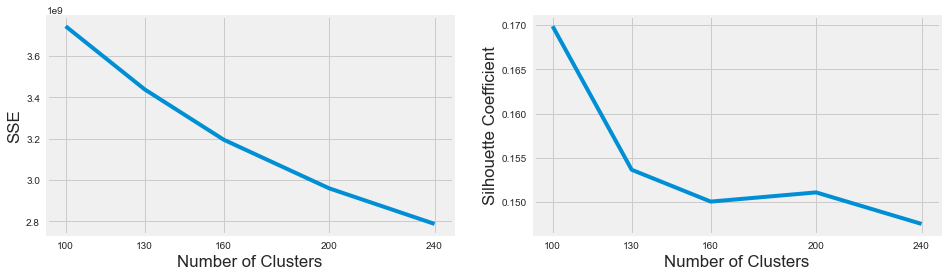

In [16]:
# fig = plt.figure(figsize=(16, 4))
# plt.style.use("fivethirtyeight")

# fig.add_subplot(1, 2, 1)
# plt.plot(ks, sse)
# plt.xticks(ks)
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")

# fig.add_subplot(1, 2, 2)
# plt.plot(ks, silhouette_coefficients)
# plt.xticks(ks)
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Coefficient")

In [239]:
def kmeans_bow(all_descriptors, num_cluster):
    kmeans = KMeans(n_clusters = num_cluster, verbose=1)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    #if not os.path.isfile('bow_dictionary.pkl'):
    pickle.dump(bow_dict, open('bow_dictionary.pkl', 'wb'))

    return kmeans, bow_dict

In [240]:
num_cluster = 200
kmeans, bow = kmeans_bow(all_descriptors, num_cluster)

Initialization complete
Iteration 0, inertia 5267935232.0
Iteration 1, inertia 3846608896.0
Iteration 2, inertia 3755055872.0
Iteration 3, inertia 3719705856.0
Iteration 4, inertia 3700080640.0
Iteration 5, inertia 3687613440.0
Iteration 6, inertia 3678492928.0
Iteration 7, inertia 3670225152.0
Iteration 8, inertia 3663309568.0
Iteration 9, inertia 3658083328.0
Iteration 10, inertia 3653664256.0
Iteration 11, inertia 3649823744.0
Iteration 12, inertia 3646554880.0
Iteration 13, inertia 3643827200.0
Iteration 14, inertia 3641428224.0
Iteration 15, inertia 3639247104.0
Iteration 16, inertia 3637396992.0
Iteration 17, inertia 3635882240.0
Iteration 18, inertia 3634506752.0
Iteration 19, inertia 3633227776.0
Iteration 20, inertia 3631994624.0
Iteration 21, inertia 3630866944.0
Iteration 22, inertia 3629552896.0
Iteration 23, inertia 3628082432.0
Iteration 24, inertia 3626571008.0
Iteration 25, inertia 3625045504.0
Iteration 26, inertia 3623804160.0
Iteration 27, inertia 3622817024.0
Iterat

Iteration 84, inertia 3621114112.0
Iteration 85, inertia 3621111808.0
Iteration 86, inertia 3621110784.0
Iteration 87, inertia 3621110528.0
Iteration 88, inertia 3621109760.0
Iteration 89, inertia 3621108736.0
Iteration 90, inertia 3621108736.0
Iteration 91, inertia 3621103616.0
Iteration 92, inertia 3621103616.0
Iteration 93, inertia 3621102080.0
Iteration 94, inertia 3621101056.0
Iteration 95, inertia 3621100800.0
Iteration 96, inertia 3621099776.0
Converged at iteration 96: center shift 0.10297501087188721 within tolerance 0.10645063476562501.
Initialization complete
Iteration 0, inertia 5259549696.0
Iteration 1, inertia 3842062592.0
Iteration 2, inertia 3751793152.0
Iteration 3, inertia 3712873216.0
Iteration 4, inertia 3691551232.0
Iteration 5, inertia 3678502912.0
Iteration 6, inertia 3668614144.0
Iteration 7, inertia 3660953344.0
Iteration 8, inertia 3655024384.0
Iteration 9, inertia 3650357760.0
Iteration 10, inertia 3646196224.0
Iteration 11, inertia 3642421248.0
Iteration 12,

Iteration 118, inertia 3628186880.0
Iteration 119, inertia 3628187136.0
Iteration 120, inertia 3628186624.0
Iteration 121, inertia 3628186624.0
Iteration 122, inertia 3628186368.0
Converged at iteration 122: center shift 0.0028171814046800137 within tolerance 0.10645063476562501.
Initialization complete
Iteration 0, inertia 5258121728.0
Iteration 1, inertia 3838210304.0
Iteration 2, inertia 3747472896.0
Iteration 3, inertia 3715756288.0
Iteration 4, inertia 3697652224.0
Iteration 5, inertia 3685457920.0
Iteration 6, inertia 3676394240.0
Iteration 7, inertia 3669544192.0
Iteration 8, inertia 3664209664.0
Iteration 9, inertia 3659821568.0
Iteration 10, inertia 3655686400.0
Iteration 11, inertia 3652360960.0
Iteration 12, inertia 3649744896.0
Iteration 13, inertia 3647319552.0
Iteration 14, inertia 3645008640.0
Iteration 15, inertia 3642946304.0
Iteration 16, inertia 3641084416.0
Iteration 17, inertia 3639433216.0
Iteration 18, inertia 3638037760.0
Iteration 19, inertia 3636939008.0
Itera

Iteration 140, inertia 3617407744.0
Iteration 141, inertia 3617402880.0
Iteration 142, inertia 3617400320.0
Iteration 143, inertia 3617395968.0
Iteration 144, inertia 3617392896.0
Iteration 145, inertia 3617391104.0
Iteration 146, inertia 3617388544.0
Iteration 147, inertia 3617386240.0
Iteration 148, inertia 3617384960.0
Iteration 149, inertia 3617382400.0
Iteration 150, inertia 3617380096.0
Iteration 151, inertia 3617378304.0
Iteration 152, inertia 3617376768.0
Iteration 153, inertia 3617374464.0
Iteration 154, inertia 3617370112.0
Iteration 155, inertia 3617368832.0
Iteration 156, inertia 3617365504.0
Iteration 157, inertia 3617366272.0
Iteration 158, inertia 3617366784.0
Converged at iteration 158: center shift 0.044800933450460434 within tolerance 0.10645063476562501.
Initialization complete
Iteration 0, inertia 5266548736.0
Iteration 1, inertia 3844187392.0
Iteration 2, inertia 3745501696.0
Iteration 3, inertia 3708168704.0
Iteration 4, inertia 3687919104.0
Iteration 5, inertia 3

Iteration 16, inertia 3642497536.0
Iteration 17, inertia 3641014272.0
Iteration 18, inertia 3639383808.0
Iteration 19, inertia 3637829632.0
Iteration 20, inertia 3636698880.0
Iteration 21, inertia 3635693312.0
Iteration 22, inertia 3634693120.0
Iteration 23, inertia 3633744128.0
Iteration 24, inertia 3632970240.0
Iteration 25, inertia 3632116992.0
Iteration 26, inertia 3631127808.0
Iteration 27, inertia 3630280448.0
Iteration 28, inertia 3629656832.0
Iteration 29, inertia 3629189376.0
Iteration 30, inertia 3628793344.0
Iteration 31, inertia 3628467200.0
Iteration 32, inertia 3628135936.0
Iteration 33, inertia 3627832064.0
Iteration 34, inertia 3627542784.0
Iteration 35, inertia 3627240448.0
Iteration 36, inertia 3626930688.0
Iteration 37, inertia 3626637568.0
Iteration 38, inertia 3626307584.0
Iteration 39, inertia 3626013440.0
Iteration 40, inertia 3625709312.0
Iteration 41, inertia 3625444608.0
Iteration 42, inertia 3625236480.0
Iteration 43, inertia 3625083648.0
Iteration 44, inerti

Iteration 70, inertia 3621306880.0
Iteration 71, inertia 3621300480.0
Iteration 72, inertia 3621290752.0
Iteration 73, inertia 3621275392.0
Iteration 74, inertia 3621254144.0
Iteration 75, inertia 3621236480.0
Iteration 76, inertia 3621215744.0
Iteration 77, inertia 3621199872.0
Iteration 78, inertia 3621185024.0
Iteration 79, inertia 3621163776.0
Iteration 80, inertia 3621143552.0
Iteration 81, inertia 3621125120.0
Iteration 82, inertia 3621109248.0
Iteration 83, inertia 3621089280.0
Iteration 84, inertia 3621071616.0
Iteration 85, inertia 3621051648.0
Iteration 86, inertia 3621030912.0
Iteration 87, inertia 3621006848.0
Iteration 88, inertia 3620980224.0
Iteration 89, inertia 3620958976.0
Iteration 90, inertia 3620935936.0
Iteration 91, inertia 3620923904.0
Iteration 92, inertia 3620916224.0
Iteration 93, inertia 3620907776.0
Iteration 94, inertia 3620902400.0
Iteration 95, inertia 3620896768.0
Iteration 96, inertia 3620885504.0
Iteration 97, inertia 3620867584.0
Iteration 98, inerti

Iteration 114, inertia 3619787776.0
Iteration 115, inertia 3619762688.0
Iteration 116, inertia 3619741952.0
Iteration 117, inertia 3619718656.0
Iteration 118, inertia 3619702272.0
Iteration 119, inertia 3619685120.0
Iteration 120, inertia 3619674112.0
Iteration 121, inertia 3619662592.0
Iteration 122, inertia 3619651840.0
Iteration 123, inertia 3619644416.0
Iteration 124, inertia 3619638528.0
Iteration 125, inertia 3619635456.0
Iteration 126, inertia 3619634176.0
Iteration 127, inertia 3619631104.0
Iteration 128, inertia 3619628288.0
Iteration 129, inertia 3619625728.0
Iteration 130, inertia 3619624192.0
Iteration 131, inertia 3619622400.0
Iteration 132, inertia 3619622144.0
Iteration 133, inertia 3619621376.0
Iteration 134, inertia 3619620096.0
Iteration 135, inertia 3619618048.0
Iteration 136, inertia 3619617280.0
Iteration 137, inertia 3619616256.0
Iteration 138, inertia 3619614976.0
Iteration 139, inertia 3619612160.0
Iteration 140, inertia 3619610112.0
Iteration 141, inertia 36196

### Create features from bow

In [241]:
def create_feature_bow(image_descriptors, bow, num_cluster):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster, dtype=float)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], bow)
            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1.0
        X_features.append(features)

    return np.array(X_features)

In [242]:
X_feature = create_feature_bow(image_descriptors, bow, num_cluster)

print("Dimensi data fitur:", X_feature.shape)

Dimensi data fitur: (2940, 200)


# Classification With SIFT

- input: `X_feature, y`
- output: -

In [243]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

In [244]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Ukuran data training:", X_train.shape[0])
print("Ukuran data testing:", X_test.shape[0])

Ukuran data training: 2499
Ukuran data testing: 441


### SVM

In [245]:
svm_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto']
}
svm_cv = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=svm_params, cv=5, verbose=3)

In [246]:
svm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...................C=1, gamma=auto;, score=0.854 total time=   0.7s
[CV 2/5] END ...................C=1, gamma=auto;, score=0.856 total time=   0.7s
[CV 3/5] END ...................C=1, gamma=auto;, score=0.876 total time=   0.7s
[CV 4/5] END ...................C=1, gamma=auto;, score=0.876 total time=   0.7s
[CV 5/5] END ...................C=1, gamma=auto;, score=0.892 total time=   0.7s
[CV 1/5] END ...................C=3, gamma=auto;, score=0.862 total time=   0.7s
[CV 2/5] END ...................C=3, gamma=auto;, score=0.848 total time=   0.7s
[CV 3/5] END ...................C=3, gamma=auto;, score=0.892 total time=   0.8s
[CV 4/5] END ...................C=3, gamma=auto;, score=0.878 total time=   0.8s
[CV 5/5] END ...................C=3, gamma=auto;, score=0.890 total time=   0.7s
[CV 1/5] END ...................C=6, gamma=auto;, score=0.860 total time=   0.7s
[CV 2/5] END ...................C=6, gamma=auto;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 3, 6, 10, 15], 'gamma': ['auto']}, verbose=3)

In [247]:
print("Model terbaik:", svm_cv.best_estimator_)
print("Score terbaik:", svm_cv.best_score_)

Model terbaik: SVC(C=10, gamma='auto')
Score terbaik: 0.8751575150300601


In [248]:
cv_results_df = pd.DataFrame(svm_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10_auto,"{'C': 10, 'gamma': 'auto'}",1,0.875158,0.016473
15_auto,"{'C': 15, 'gamma': 'auto'}",1,0.875158,0.016473
6_auto,"{'C': 6, 'gamma': 'auto'}",3,0.874758,0.017045
3_auto,"{'C': 3, 'gamma': 'auto'}",4,0.873956,0.016787
1_auto,"{'C': 1, 'gamma': 'auto'}",5,0.870757,0.014111


In [249]:
y_pred = svm_cv.predict(X_test)

In [250]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.65      0.71      0.68        21
          ca       0.96      0.85      0.90        26
          da       0.96      0.96      0.96        23
         dha       1.00      0.82      0.90        28
          ga       0.88      0.75      0.81        20
          ha       0.60      0.63      0.62        19
          ja       0.81      1.00      0.90        13
          ka       0.87      0.93      0.90        28
          la       0.64      0.56      0.60        25
          ma       1.00      1.00      1.00        22
          na       0.89      0.80      0.84        20
         nga       0.82      0.86      0.84        21
         nya       0.85      0.81      0.83        21
          pa       0.79      0.83      0.81        18
          ra       0.83      1.00      0.91        24
          sa       0.96      0.96      0.96        25
          ta       0.95      0.84      0.89        25
         tha       0.92    

### Result:
Testing : K \[ 700, 500, 350, 240, 180, 140 \]
- Img = (25,25), K = 180, SVM = 0.61
- Img = (28,28), K = 140, SVM = 0.59
- Img = (32,32), K = 140, SVM = 0.69
- Img = (64,64), K = 180, SVM = 0.89
- Img = (128,128), K = 60, KNN = 0.69, SVM = 0.82
- Img = (128,128), K = 80, KNN = 0.71, SVM = 0.88
- Img = (128,128), K = 100, KNN = 0.76, SVM = 0.90
- Img = (128,128), K = 120, KNN = 0.74, SVM = 0.91
- Img = (128,128), K = 140, KNN = 0.78, SVM = 0.92
- Img = (128,128), K = 160, KNN = 0.76, SVM = 0.93
- Img = (128,128), K = 180, KNN = 0.75, SVM = 0.92
- Img = (128,128), K = 200, KNN = 0.75, SVM = 0.94 (G,T) / 0.92 (G,E) / 0.86 (G,E,T)
- Img = (128,128), K = 240, KNN = 0.76, SVM = 0.96
- Img = (128,128), K = 350, KNN = 0.75, SVM = 0.94
- Img = (128,128), K = 500, KNN = 0.76, SVM = 0.97
- Img = (128,128), K = 700, KNN = 0.71, SVM = 0.95
- Img = (128,128), K = 1000, KNN = 0.63, SVM = 0.95

=========================================================

Sebelum:
- Img = (224,224), K = 512, KNN = 0.59, SVM = 0.92
- Img = (128,128), K = 60, KNN = 0.61, SVM = 0.85
- Img = (128,128), K = 80, KNN = 0.64, SVM = 0.88
- Img = (128,128), K = 100, KNN = 0.66, SVM = 0.89
- Img = (128,128), K = 120, KNN = 0.66, SVM = 0.90
- Img = (128,128), K = 140, KNN = 0.69, SVM = 0.92
- Img = (128,128), K = 160, KNN = 0.68, SVM = 0.93
- Img = (128,128), K = 180, KNN = 0.70, SVM = 0.91
- Img = (128,128), K = 200, KNN = 0.66, SVM = 0.92
- Img = (128,128), K = 240, KNN = 0.70, SVM = 0.92

# Classification Without SIFT

- input: `X, y`
- output: -

### Image Preprocessing

In [196]:
# new_X = X
new_X = []

for i in range(X.shape[0]) :
    new_X.append(resizing(X[i], 10))
    
new_X = np.array(new_X, dtype=np.uint8)

## Modelling

In [197]:
# reshape data
X_feature = np.reshape(new_X, (new_X.shape[0], new_X[0].shape[0]*new_X[0].shape[1]))
X_feature.shape

(2940, 50176)

In [198]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

KeyboardInterrupt: 

In [ ]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Ukuran data training:", X_train.shape[0])
print("Ukuran data testing:", X_test.shape[0])

### SVM

In [ ]:
svm_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto']
}
svm_cv = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=svm_params, cv=5, verbose=3)

In [ ]:
svm_cv.fit(X_train, y_train)

In [ ]:
print("Model terbaik:", svm_cv.best_estimator_)
print("Score terbaik:", svm_cv.best_score_)

In [ ]:
cv_results_df = pd.DataFrame(svm_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

In [173]:
y_pred = svm_cv.predict(X_test)

In [174]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.38      0.62      0.47        21
          ca       0.32      0.23      0.27        26
          da       0.65      0.48      0.55        23
         dha       0.53      0.57      0.55        28
          ga       0.70      0.70      0.70        20
          ha       0.45      0.68      0.54        19
          ja       0.36      0.38      0.37        13
          ka       0.43      0.46      0.45        28
          la       0.42      0.32      0.36        25
          ma       0.78      0.64      0.70        22
          na       0.32      0.35      0.33        20
         nga       0.73      0.90      0.81        21
         nya       0.59      0.81      0.68        21
          pa       0.36      0.44      0.40        18
          ra       0.82      0.75      0.78        24
          sa       0.56      0.40      0.47        25
          ta       0.35      0.32      0.33        25
         tha       0.68    

### Result:
- Img = (25,25), SVM = 0.57
- Img = (28,28), SVM = 0.51
- Img = (32,32), SVM = 0.54
- Img = (64,64), SVM = 0.45